In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error # MSE probably not ideal, but good enough for now
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
dp = pd.read_csv('stats_and_pay_pitchers.csv')
db = pd.read_csv('stats_and_pay_batters.csv')

# load the training/test split
train_p = pd.read_csv('datasets/train_p.csv')
test_p = pd.read_csv('datasets/test_p.csv')
train_b = pd.read_csv('datasets/train_b.csv')
test_b = pd.read_csv('datasets/test_b.csv')

In [3]:

# merge into a single df for combined use
train = pd.merge(train_p,train_b, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')
test = pd.merge(test_p,test_b, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')


# remove all the ones with zero pay
train = train[train['pay_adj']>0]
test = test[test['pay_adj']>0]

In [4]:
side_cols = ['fgid','year','Season','Season_prev','pay','log_pay','adj','pay_adj','log_pay_adj']

columns_mask = np.logical_and.reduce([~np.isin(db.columns,side_cols),
                                      np.logical_or(db.dtypes==np.float64, db.dtypes==int)])
batting_cols = train.columns[np.isin(train.columns,db.columns[columns_mask])]


columns_mask = np.logical_and.reduce([~np.isin(dp.columns,side_cols),
                                      np.logical_or(dp.dtypes==np.float64,dp.dtypes==int)])
pitching_cols = train.columns[np.isin(train.columns,dp.columns[columns_mask])]

In [5]:
%%time

# let's use the linear model as a baseline

# make an array of zeros that will hold our mses
mses = np.zeros((3, 5))

# keep track of what split we are on
i = 0


# Make a KFold object with k=5
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 2158675309)

for train_index, test_index in kfold.split(train.copy()):
    
    
    ### Training
    train_x = train.iloc[train_index].copy().fillna(0)
    payx = train_x['log_pay_adj'].values
    train_xarr = train_x[list(pitching_cols)+list(batting_cols)].values
    
    
    ### Holdout set
    train_y = train.iloc[test_index].copy().fillna(0)
    payy = train_y['log_pay_adj'].values
    train_yarr = train_y[list(pitching_cols)+list(batting_cols)].values
    

    ## Model 3
    model3 = LinearRegression(copy_X=True)
    model3.fit(train_xarr, payx)
    pred3 = model3.predict(train_yarr)
    
    ## record MSE
    mses[0,i] = mean_squared_error(payy, pred3)
    
    ## random forest
    regr = RandomForestRegressor(max_depth=12, random_state=None)
    regr.fit(train_xarr, payx)
    pred4 = regr.predict(train_yarr)
    ## record MSE
    mses[1,i] = mean_squared_error(payy, pred4)
    
    
    print('fold %i complete'%i)
    ## increase i by 1
    i = i + 1
    
for m,MSE in enumerate(mses.mean(axis=1)):
    print('Model %i mean MSE:'%(m+1), MSE)

fold 0 complete
fold 1 complete
fold 2 complete
fold 3 complete
fold 4 complete
Model 1 mean MSE: 1462649382341490.2
Model 2 mean MSE: 0.2412537436753838
Model 3 mean MSE: 0.0
CPU times: user 1min 54s, sys: 2.68 s, total: 1min 57s
Wall time: 1min 45s


Increasing the max depth of the random forest seems to improve the MSE loss. We can do even better than the linear model at max_depth=10. Lets' try manually inceasing this parameter

In [152]:
def rf_test(max_depth=None,kfold_seed=8888):
    # make an array of zeros that will hold our mses
    mses = np.zeros((1, 5))

    # keep track of what split we are on
    i = 0

    # Make a KFold object with k=5
    kfold = KFold(n_splits = 5,
                  shuffle = True,
                  random_state = kfold_seed)

    for train_index, test_index in kfold.split(train.copy()):


        ### Training
        train_x = train.iloc[train_index].copy().fillna(0)
        payx = train_x['log_pay_adj'].values
        train_xarr = train_x[list(pitching_cols)+list(batting_cols)].values


        ### Holdout set
        train_y = train.iloc[test_index].copy().fillna(0)
        payy = train_y['log_pay_adj'].values
        train_yarr = train_y[list(pitching_cols)+list(batting_cols)].values

        ## random forest
        regr = RandomForestRegressor(max_depth=max_depth, random_state=None)
        regr.fit(train_xarr, payx)
        pred4 = regr.predict(train_yarr)
        ## record MSE
        mses[0,i] = mean_squared_error(payy, pred4)


        #print('fold %i complete'%i)
        ## increase i by 1
        i = i + 1
        
    return mses.mean(axis=1)[0]

In [6]:
# now let's use model 3 on the whole training and test set
reg = RandomForestRegressor(max_depth=12, random_state=None)
full_train = train[list(pitching_cols)+list(batting_cols)].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
reg.fit(full_train, train['log_pay_adj'].values)

full_test = test[list(pitching_cols)+list(batting_cols)].fillna(0).values
pred0 = reg.predict(full_test)

mean_squared_error(test['log_pay_adj'].values, pred0)

0.23233437729832776

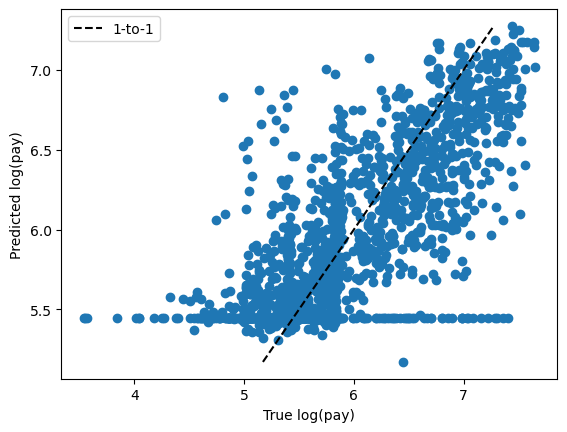

In [9]:
# while there's generally a linear correlation, it seems there is some sort of features we are missing
plt.scatter(test['log_pay_adj'].values, pred0)
plt.plot([min(pred0), max(pred0)],[min(pred0), max(pred0)],'k--', label='1-to-1')
plt.xlabel('True log(pay)')
plt.ylabel('Predicted log(pay)')
plt.legend()

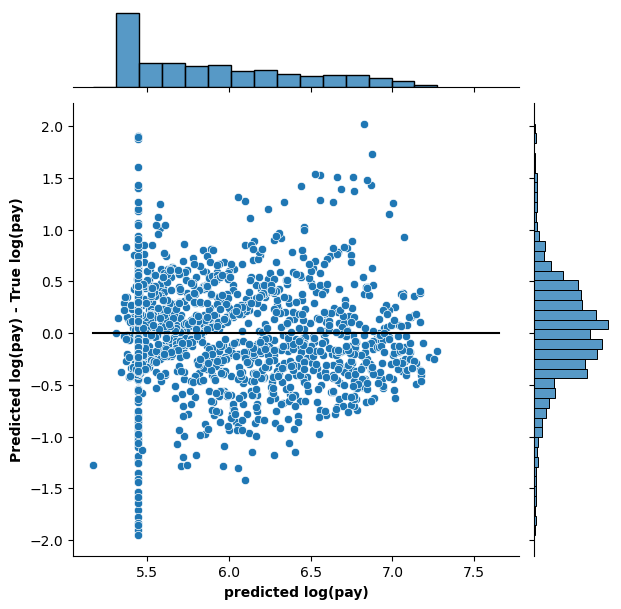

In [10]:
# plot the residuals
p = sns.jointplot(x=pred0,y=pred0-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('predicted log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')

p.ax_joint.plot([min(pred0),max(test['log_pay_adj'].values)], np.ones(2)*0,color='black',label='zero residuals')
#X = np.linspace(min(test['log_pay_adj'].values), max(test['log_pay_adj'].values))
#p.ax_joint.plot(X, 6.1-X,color='red')

This is probably a mixture model?

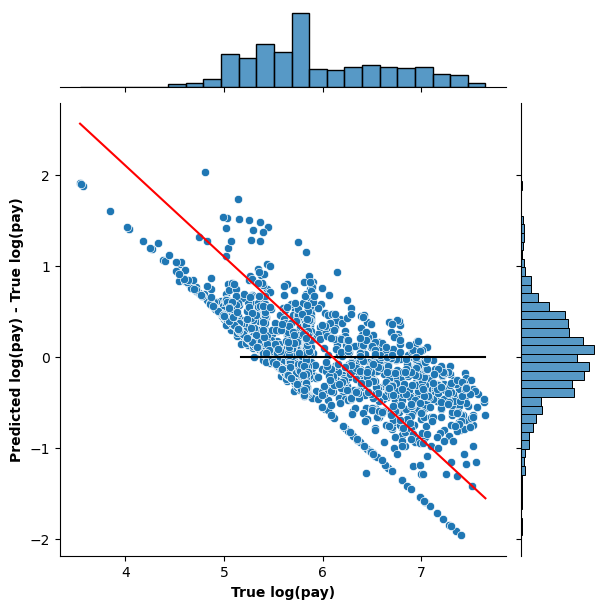

In [11]:
# plot the residuals
p = sns.jointplot(x=test['log_pay_adj'].values,y=pred0-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')

p.ax_joint.plot([min(pred0),max(test['log_pay_adj'].values)], np.ones(2)*0,color='black',label='zero residuals')
X = np.linspace(min(test['log_pay_adj'].values), max(test['log_pay_adj'].values))
p.ax_joint.plot(X, 6.1-X,color='red')

## Use pay instead of log pay
What if we tried to fit to not the log of the pay, but the pay directly (MSE is probably wrong, so we'll use logloss)

In [77]:
%%time

# let's use the linear model as a baseline

# make an array of zeros that will hold our loss
logls = np.zeros((3, 5))

# keep track of what split we are on
i = 0


# Make a KFold object with k=5
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 2158675309)

for train_index, test_index in kfold.split(train.copy()):
    
    
    ### Training
    train_x = train.iloc[train_index].copy().fillna(0)
    payx = train_x['pay_adj'].values
    train_xarr = train_x[list(pitching_cols)+list(batting_cols)].values
    
    
    ### Holdout set
    train_y = train.iloc[test_index].copy().fillna(0)
    payy = train_y['pay_adj'].values
    train_yarr = train_y[list(pitching_cols)+list(batting_cols)].values
    

    ## Model 3
    model3 = LinearRegression(copy_X=True)
    model3.fit(train_xarr, payx)
    pred3 = model3.predict(train_yarr)
    
    ## record MSE
    logls[0,i] =  mean_absolute_percentage_error(payy, pred3)
    
    ## random forest
    regr = RandomForestRegressor(max_depth=12, random_state=None)
    regr.fit(train_xarr, payx)
    pred4 = regr.predict(train_yarr)
    ## record MSE
    logls[1,i] =  mean_absolute_percentage_error(payy, pred4)
    
    
    print('fold %i complete'%i)
    ## increase i by 1
    i = i + 1
    
for m,logl in enumerate(logls.mean(axis=1)):
    print('Model %i mean log loss:'%(m+1), logl)

fold 0 complete
fold 1 complete
fold 2 complete
fold 3 complete
fold 4 complete
Model 1 mean log loss: 5.76137971039149
Model 2 mean log loss: 4.295993379212044
Model 3 mean log loss: 0.0
CPU times: user 1min 6s, sys: 2.5 s, total: 1min 9s
Wall time: 59.1 s


In [98]:
# now let's use model 3 on the whole training and test set
reg = RandomForestRegressor(max_depth=12, random_state=None)
full_train = train[list(pitching_cols)+list(batting_cols)].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
reg.fit(full_train, train['pay_adj'].values)

full_test = test[list(pitching_cols)+list(batting_cols)].fillna(0).values
pred = reg.predict(full_test)

mean_absolute_percentage_error(test['pay_adj'].values, pred)

3.93440820408113

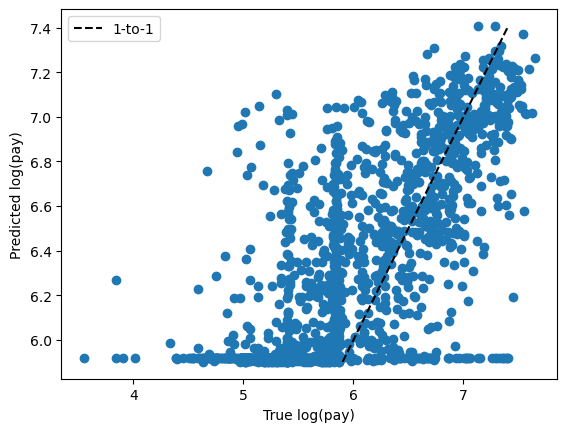

In [99]:
# while there's generally a linear correlation, it seems there is some sort of features we are missing
plt.scatter(test['log_pay_adj'].values, np.log10(pred))


plt.plot([min(np.log10(pred)), max(np.log10(pred))],[min(np.log10(pred)), max(np.log10(pred))],'k--', label='1-to-1')
plt.xlabel('True log(pay)')
plt.ylabel('Predicted log(pay)')
plt.legend()

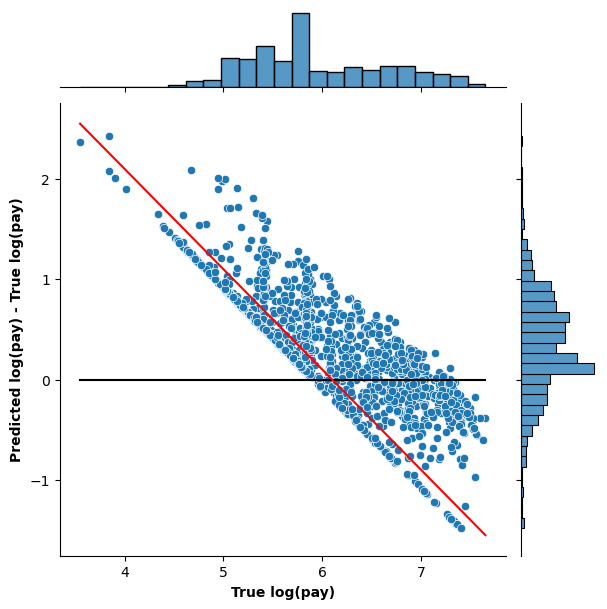

In [101]:
# plot the residuals
p = sns.jointplot(x=test['log_pay_adj'].values,y=np.log10(pred)-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')

p.ax_joint.plot([min(test['log_pay_adj'].values),max(test['log_pay_adj'].values)], np.ones(2)*0,color='black',label='zero residuals')

X = np.linspace(min(test['log_pay_adj'].values), max(test['log_pay_adj'].values))
p.ax_joint.plot(X,6.1-X,color='red')

# Shift by a linear model?
(Really should be plotting residuals against predicted...)

In [117]:
m = -1
b = 6.1
pred_shift = np.log10(pred) - (b + np.log10(pred))/(1-m)

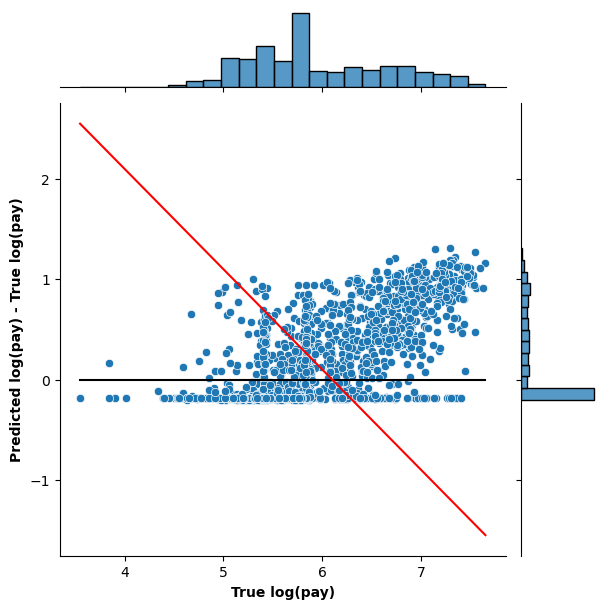

In [118]:
# plot the residuals
ytru = test['log_pay_adj'].values
p = sns.jointplot(x=ytru,y=np.log10(pred)-ytru -m*ytru-b ,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')

p.ax_joint.plot([min(test['log_pay_adj'].values),max(test['log_pay_adj'].values)], np.ones(2)*0,color='black',label='zero residuals')

X = np.linspace(min(test['log_pay_adj'].values), max(test['log_pay_adj'].values))
p.ax_joint.plot(X, m*X+b,color='red')